# Creating Animations with SymPy and Matplotlib

[back to SymPy page](index.ipynb)

[General information about Matplotlib animations](../plotting/matplotlib-animation.ipynb)

By default, SymPy uses Matplotlib for plotting,
but it is not quite straightforward to create
Matplotlib animations from SymPy plots.

This notebook shows a few ways how to get those animations running.

First, let's import some stuff from Matplotlib:

In [1]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

... and some stuff from SymPy:

In [2]:
import sympy as sp
from sympy.plotting.plot import MatplotlibBackend

In [3]:
x = sp.symbols('x')

Here we want to use JavaScript-based animations, for other options see
[the Matplotlib animation notebook](../plotting/matplotlib-animation.ipynb).

In [4]:
plt.rcParams['animation.html'] = 'jshtml'

## Changing the Plotted Expression

One way for creating an animation is to create a single
[Plot](https://docs.sympy.org/latest/modules/plotting.html#sympy.plotting.plot.Plot) object
and later change the associated SymPy expression for each frame.

When we create the `Plot` object,
we just use a dummy expression,
but we should already select the desired range.

Note that we only want to get the `Plot` object,
we don't want to actually show the plot yet.

In [5]:
p = sp.plot(0, (x, 0, 2 * sp.pi), show=False)

Normally, SymPy takes care of the plotting backend automatically,
but here we want to explicitly control the backend.

In [6]:
backend = MatplotlibBackend(p)
plt.close(backend.fig)  # Avoid showing empty plot here

In the animation function, we simply have to switch the expression.

The tricky part is that we have to manually trigger the backend
in order to create the plot for the current frame.
And we have to make sure the previous content of the plot is erased.

In [7]:
def func(frame):
    backend.ax.clear()
    p[0].expr = sp.sin(x - (frame / 5))
    # If there are multiple plots, also change p[1], p[2] etc.
    backend.process_series()

The rest is simple, we just have to use the `Figure` object from the SymPy backend
to create the animation.

In [8]:
ani = FuncAnimation(backend.fig, func, frames=10)

In [9]:
ani

## Changing the Whole Plot

If changing the expression isn't enough
(e.g. if you want to change the range of a plot),
you can use a slightly different approach.

In [10]:
p = sp.plot(0, show=False)
backend = MatplotlibBackend(p)
plt.close(backend.fig)  # Avoid showing empty plot here

In [11]:
def func(frame):
    backend.parent = sp.plot(sp.sin(x), (x, 0, 2 * sp.pi * (1 + frame/10)), show=False)
    backend.process_series()

In [12]:
ani = FuncAnimation(backend.fig, func, frames=10)

In [13]:
ani

## Plotting into an Existing Figure/Axes Object

SymPy normally creates `Figure` and `Axes` objects on its own.

To make it plot into an existing `Axes` object,
we can use a trick from https://stackoverflow.com/a/46813804.

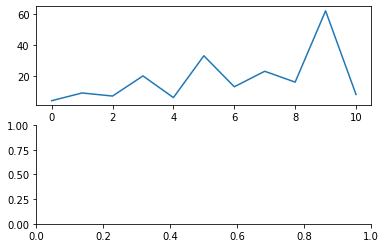

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.plot([4, 9, 7, 20, 6, 33, 13, 23, 16, 62, 8]);
ax2.spines['top'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.spines['bottom'].set_position('zero')

In [15]:
def func(frame):
    ax2.clear()
    p = sp.plot(sp.sin(x - (frame / 5)), (x, 0, 2 * sp.pi), show=False)
    backend = MatplotlibBackend(p)
    backend.ax = ax2
    backend.process_series()
    plt.close(backend.fig)

In [16]:
ani = FuncAnimation(fig, func, frames=10)

In [17]:
ani

## Changing an Existing Matplotlib Plot with Data from SymPy

If we want, we can completely circumvent SymPy's `MatplotlibBackend`
by just getting the coordinates to be plotted from SymPy.

This approach should also work with plotting frameworks other than Matplotlib.

### Using `get_points()`

First, we create an empty plot of the desired size:

In [18]:
fig, ax = plt.subplots()
ax.set_xlim(0, 6.3)
ax.set_ylim(-1.1, 1.1);
plt.close(fig)

We plot a line with no data (and whatever settings we like) and keep the
[Line2D](https://matplotlib.org/api/_as_gen/matplotlib.lines.Line2D.html)
object around for later:

In [19]:
line, = ax.plot([], 'r')

The animation function just updates the `Line2D` object
with points calculated by SymPy:

In [20]:
def func(frame):
    p = sp.plot(sp.sin(x - (frame / 5)), (x, 0, 2 * sp.pi), show=False)
    line.set_data(p[0].get_points())
    return line

In [21]:
ani = FuncAnimation(fig, func, frames=10)

In [22]:
ani

### Using `get_segments()`

The function `get_points()` just evaluates the function
at a certain number of equidistant points.

SymPy provides a more elaborate way to get data for the plot:
[get_segments()](https://docs.sympy.org/latest/modules/plotting.html#sympy.plotting.plot.LineOver1DRangeSeries.get_segments).
This uses adaptive sampling, which might give better results for certain types of functions.

The segments obtained from SymPy can be used in Matplotlib's
[LineCollection](https://matplotlib.org/api/collections_api.html#matplotlib.collections.LineCollection),
and they can be replaced with
[set_segments()](https://matplotlib.org/api/collections_api.html#matplotlib.collections.LineCollection.set_segments).

In [23]:
from matplotlib.collections import LineCollection

In [24]:
fig, ax = plt.subplots()
ax.set_xlim(0, 6.3)
ax.set_ylim(-1.1, 1.1);
plt.close(fig)

Add `LineCollection` without data:

In [25]:
lines = LineCollection([])
ax.add_collection(lines);

The animation function just updates the `LineCollection` with segments calculated by SymPy:

In [26]:
def func(frame):
    p = sp.plot(sp.sin(x - (frame / 5)), (x, 0, 2 * sp.pi), show=False)
    lines.set_segments(p[0].get_segments())
    return lines

In [27]:
ani = FuncAnimation(fig, func, frames=10)

In [28]:
ani